# Setup

In [1]:
import os
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import cartopy.util as cutil
import cmocean
import matplotlib
import matplotlib.animation as animation
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.27.0
  warnings.warn(
ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/zespinosa/conda-envs/cenv/share/proj failed


# Plotting Utils

In [2]:
def plot_stationary_sp(nplots: int = 3, minLon: int = -180, maxLon: int = 180):
    """
    TODO: Add Doc String
    Create a stationary centered on south pole (Longitude: [minLon,maxLon]; Latitude: [-90,-60]
    Returns:
        ax, fig
    """
    # Create subplots
    if nplots == 3:
        figsize = [20, 20]
    if nplots == 2:
        figsize = [10, 10]
    if nplots == 1:
        figsize = [5, 5]

    fig, axs = plt.subplots(nrows=1, ncols=nplots, figsize=figsize, subplot_kw=dict(projection=ccrs.SouthPolarStereo()))
    fig.subplots_adjust(bottom=0.05, top=0.95, left=0.04, right=0.95, wspace=0.15)

    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    if nplots == 1:
        axs =  [axs]

    # Add properties to axes
    for ax in axs:
        # Limit the map to -60 degrees latitude and below.
        ax.set_extent([minLon, maxLon, -90, -50], ccrs.PlateCarree())

        ax.gridlines(draw_labels=True, color="black", linestyle="dashed", zorder=101)
        ax.tick_params(which="both", zorder=103)

        ax.add_feature(cartopy.feature.LAND, facecolor="grey", edgecolor="black", zorder=3)
        ax.add_feature(cartopy.feature.OCEAN, facecolor="white")


        ax.set_boundary(circle, transform=ax.transAxes)

    return fig, axs

def interpolate_seaice_gap(ds):
    """
    There is an issue in the sea ice data at longitude 319.5 and 320.5 (indices 319 and 320).
    This function fills the gap by taking linear interpolation between the two points on 
    either side of the gap (indices 318 and 321).
    """
    ds[:, 319] = ds[:, 318] + (ds[:, 321] - ds[:, 318])/3
    ds[:, 320] = ds[:, 318] + (ds[:, 321] - ds[:, 318])*2/3
    return ds


In [30]:
def spatial_obs_plot(dfs, cmap_info, save_info):
    fig, axes = plot_stationary_sp(nplots=len(dfs.keys()))

    for i, ((key, ds), ax) in enumerate(zip(dfs.items(), axes)):

        if not cmap_info["shared"]:
            levels = cmap_info["levels"][i]
            units = cmap_info["units"][i]
            cmap = cmap_info["cmap"][i]
        else: 
            levels = cmap_info["levels"]
            units = cmap_info["units"]
            cmap = cmap_info["cmap"]

        # Create contour plot
        dsi = interpolate_seaice_gap(ds["ds"].values)
        img = ax.contourf(
            ds["ds"].lon.values,
            ds["ds"].lat.values,
            ds["ds"].values,
            transform=ccrs.PlateCarree(), 
            levels=levels,
            extend="both",
            cmap=cmap,
        )
        
        # Add ice edge
        if key.split("_")[-1] == "siconc":
            dsi = interpolate_seaice_gap(ds["edge"].values)
            ax.contour(
                ds["edge"].lon.values,
                ds["edge"].lat.values,
                dsi,
                transform=ccrs.PlateCarree(), 
                levels=[.15],
                colors="navy"
            )
            dsi = interpolate_seaice_gap(ds["edge_clim"].values)
            ax.contour(
                ds["edge_clim"].lon.values,
                ds["edge_clim"].lat.values,
                ds["edge_clim"].values,
                transform=ccrs.PlateCarree(), 
                levels=[.15],
                colors="magenta",
            )
            if "edge_ens" in ds.keys():
                ax.contour(
                    ds["edge_ens"].lon.values,
                    ds["edge_ens"].lat.values,
                    ds["edge_ens"].values,
                    transform=ccrs.PlateCarree(), 
                    levels=[.15],
                    colors="blue",
                )

        # Plot Winds if given
        if "wind" in ds.keys():
            lat_step, lon_step = 5, 5 
            ax.quiver(
                x=ds["wind"][0].lon[::lon_step],
                y=ds["wind"][0].lat[::lat_step],
                u=ds["wind"][0].values[::lat_step, ::lon_step], 
                v=ds["wind"][1].values[::lat_step, ::lon_step], 
                color="black", 
                scale=ds["wind"][2],
                transform=ccrs.PlateCarree(),
            )

        if not cmap_info["shared"]:
            cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=.046, pad=0.04)
            cbar.ax.set_title(units)
            if "ticks" in cmap_info.keys():
                cbar.set_ticks(cmap_info["ticks"])
                cbar.set_ticklabels(cmap_info["ticks"])

        # Set properties
        if "title" in ds.keys():
            ax.set_title(ds["title"], loc="right", fontweight="bold")

        if "left_title" in ds.keys():
            ax.set_title(ds["left_title"], loc="left", fontweight="bold")

    if len(dfs) == 3: 
        fraction = .016
    else: 
        fraction = .026

    if cmap_info["shared"]:
        cbar = fig.colorbar(img, ax=axes.ravel().tolist(), orientation="vertical", fraction=fraction, pad=0.04)
        cbar.ax.set_title(cmap_info["units"])
        if "ticks" in cmap_info.keys():
            cbar.set_ticks(cmap_info["ticks"])
            cbar.set_ticklabels(cmap_info["ticks"])

    if save_info["save"]:
        plt.savefig(save_info["path"], dpi=save_info["dpi"], bbox_inches="tight")


# Analysis

## Figure 1

### Sea ice (a and b)

/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages/xarray/coding/times.py:682: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages/xarray/coding/times.py:682: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/zespinosa/conda-en

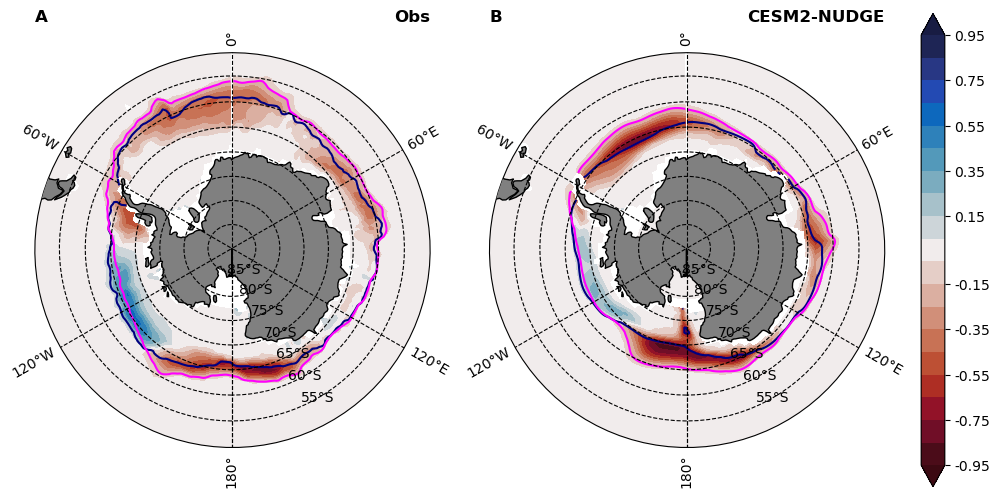

In [24]:
##### BASE CASE WITH NUDGING ####
cesm2_ice_anoms = xr.open_dataset("../data/cesm2_ice_monthly_1950-01_2023-12-anoms.nc")
cesm2_ice = xr.open_dataset("../data/cesm2_ice_monthly_1950-01_2023-12-regrid.nc")
cesm2_ice_clim = xr.open_dataset("../data/cesm2_ice_monthly_1950-01_2023-12-clim.nc")

##### NSIDC Observed Sea Ice #####
nsidc_ice_anoms = xr.open_dataset("../data/nsidc_regrid-anoms.nc")
nsidc_ice = xr.open_dataset("../data/nsidc_regrid.nc")
nsidc_ice_clim = xr.open_dataset("../data/nsidc_regrid-clim.nc")

save_info = {
    "save": True,
    "path": "figures/Figure_1a.png",
    "dpi": 400,
}

cmap_info = {
    "cmap": cmocean.cm.balance_r,
    "units": "",
    "shared": True,
    "levels": np.arange(-.95, 1.05, .1),
    "ticks": [-.95, -.75, -.55, -.35, -.15, .15, .35, .55, .75, .95],
    "tick_labels": [-.95, -.75, -.55, -.35, -.15, .15, .35, .55, .75, .95],
}

nsidc_siconc = {
    "title": "Obs",
    "ds": nsidc_ice_anoms["cdr_seaice_conc"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
    "edge": nsidc_ice["cdr_seaice_conc"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Navy (2023 JJA)
    "edge_clim": nsidc_ice_clim["cdr_seaice_conc"].resample(time="QS-DEC").mean(dim="time").isel(time=2).squeeze(), # Magenta - Climatology 
    "left_title": "A"
}

cesm2_siconc = {
    "title": "CESM2-NUDGE",
    "ds": cesm2_ice_anoms["aice"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
    "edge": cesm2_ice["aice"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Navy (2023 JJA)
    "edge_clim": cesm2_ice_clim["aice"].resample(time="QS-DEC").mean(dim="time").isel(time=2).squeeze(), # Magenta - Climatology 
    "left_title": "B"
}

spatial_obs_plot(
    dfs={
        "nsidc_siconc":  nsidc_siconc, 
        "cesm2_siconc": cesm2_siconc,
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

### sst (c and d)

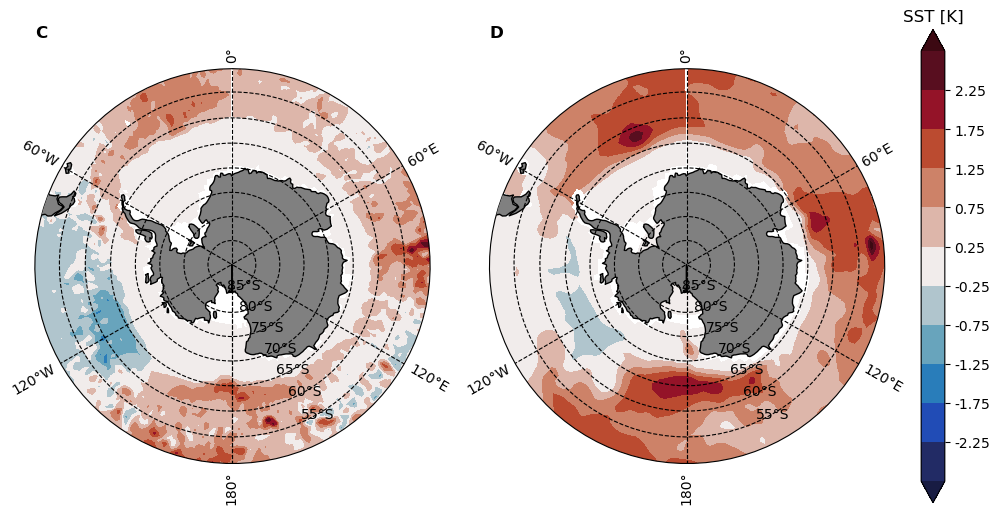

In [32]:
cesm2_sst_anoms = xr.open_dataset("../data/cesm2_ocn-sst_monthly_1950-01_2023-12-anoms.nc")
era5_atm_anoms = xr.open_dataset("../data/ERA5_monthly_1979-01_2023-12_full-single-anoms.nc")

save_info = {
    "save": True,
    "path": "figures/Figure_1cd.png",
    "dpi": 400,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"SST [K]",
    "levels": np.arange(-2.75, 3.25, .5),
    "shared": True,
    "ticks": [-2.25, -1.75, -1.25, -.75, -.25, .25, .75, 1.25, 1.75, 2.25],
    "tick_labels": [-2.25, -1.75, -1.25, -.75, -.25, .25, .75, 1.25, 1.75, 2.25],
}

era5 = {
    "ds": era5_atm_anoms["sst"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
    "left_title": "C"
}
cesm2 = {
    "ds": cesm2_sst_anoms["SST"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
    "left_title": "D"
}

spatial_obs_plot(
    dfs={
        "era5": era5, 
        "cesm2": cesm2,
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

### mslp and winds

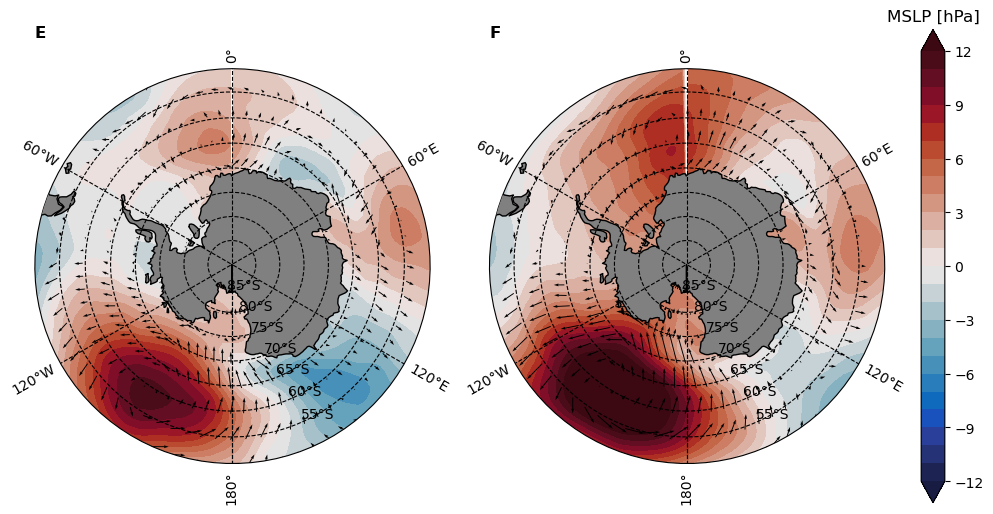

In [34]:
cesm2_atm_anoms = xr.open_dataset("../data/cesm2_atm_monthly_1950-01_2023-12-anoms.nc")
era5_atm_anoms = xr.open_dataset("../data/ERA5_monthly_1979-01_2023-12_full-single-anoms.nc")

save_info = {
    "save": True,
    "path": "figures/Figure_1ef.png",
    "dpi": 400,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"MSLP [hPa]",
    "levels": np.arange(-12, 13, 1),
    "shared": True
}

era5 = {
    "title": "",
    "left_title": "E",
    "ds": era5_atm_anoms["msl"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze()/100,
    "wind": [
        era5_atm_anoms["u10"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Zonal
        era5_atm_anoms["v10"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Meridional
        75
    ]
}

cesm2 = {
    "title": "",
    "left_title": "F",
    "ds": cesm2_atm_anoms["PSL"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze()/100,
    "wind": [
        cesm2_atm_anoms["U"].isel(lev=0).resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Zonal
        cesm2_atm_anoms["V"].isel(lev=0).resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Meridional
        75,
    ]
}

spatial_obs_plot(
    dfs={
        "era5": era5, 
        "cesm2": cesm2,
    },
    cmap_info=cmap_info, 
    save_info=save_info, 
)

## Sea Ice Thickness

In [76]:
##### BASE CASE WITH NUDGING ####
cesm2_ice_anoms = xr.open_dataset("../data/cesm2_ice_monthly_1950-01_2023-12-anoms.nc")
cesm2_ice = xr.open_dataset("../data/cesm2_ice_monthly_1950-01_2023-12-regrid.nc")
cesm2_ice_clim = xr.open_dataset("../data/cesm2_ice_monthly_1950-01_2023-12-clim.nc")
# cesm2_ice_clim = cesm2_ice_clim["aice"].resample(time="QS-DEC").mean(dim="time").isel(time=2).squeeze()

##### ENSEMBLE FORECAST ####
# cesm2_ice_anoms = xr.open_dataset("../data/persistence_ensemble/1980/1980_cesm2_ice_monthly_1950-01_2023-12-anoms.nc")
# ens = []
# ens_mems = members = ["1980", "1989", "1994", "1998", "1999", "2005", "2007", "2014"]
# for mem in ens_mems: 
#     cesm2_ice_ens = xr.open_dataset(f"../data/persistence_ensemble/{mem}/{mem}_cesm2_ice_monthly_1950-01_2023-12-regrid.nc")["aice"]
#     ens.append(cesm2_ice_ens)
# aice_ens = xr.concat(ens, "year")
# aice_ens
nsidc_ice = xr.open_dataset("../data/nsidc_regrid.nc")
# nsidc_ice

/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages/xarray/coding/times.py:682: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages/xarray/coding/cftime_offsets.py:292: CFWarning: this date/calendar/year zero convention is not supported by CF
  return date.replace(year=year, month=month, day=day)


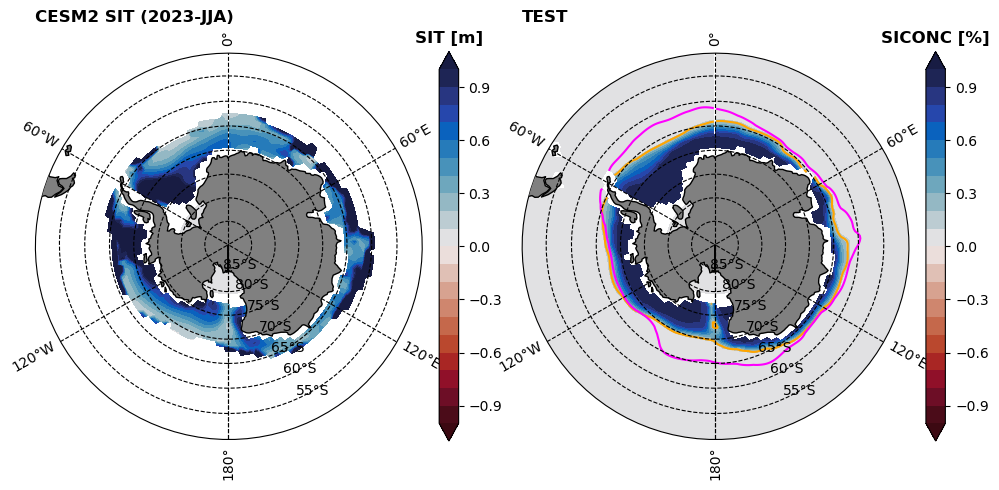

In [74]:
save_info = {
    "save": False,
    "path": "figures/tes.png",
    "dpi": 400,
}

cmap_info = {
    "cmap": [cmocean.cm.balance_r, cmocean.cm.balance_r],
    "units": ["SIT [m]", "SICONC [%]"],
    "shared": False,
    "levels": [np.arange(-1, 1.1, .1), np.arange(-1, 1.1, .1)]
}

cesm2_thickness = {
    "title": "CESM2 SIT (2023-JJA)",
    # "ds": cesm2_ice_anoms["sithick"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
    "ds": cesm2_ice["sithick"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
}

cesm2_siconc = {
    "title": "TEST",
    # "ds": cesm2_ice_anoms["aice"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
    "ds": cesm2_ice["aice"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), #- aice_ens.mean("year").resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
    "edge": cesm2_ice["aice"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Orange - Nudged
    "edge_clim": cesm2_ice_clim["aice"].resample(time="QS-DEC").mean(dim="time").isel(time=2).squeeze(), # Magenta - Climatology 
    # "edge_ens": aice_ens.mean("year").resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Blue - Free Ensemble
}

spatial_obs_plot(
    dfs={
        "cesm2_thickness":  cesm2_thickness, 
        "cesm2_siconc": cesm2_siconc,
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

## ATM

In [8]:
cesm2_atm_anoms = xr.open_dataset("../data/cesm2_atm_monthly_1950-01_2023-12-anoms.nc")
era5_atm_anoms = xr.open_dataset("../data/ERA5_monthly_1979-01_2023-12_full-single-anoms.nc")
era5_atm_anoms
# cesm2_atm_anoms

<xarray.Dataset>
Dimensions:  (time: 538, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-10-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    u10      (time, lat, lon) float64 ...
    v10      (time, lat, lon) float64 ...
    si10     (time, lat, lon) float64 ...
    t2m      (time, lat, lon) float64 ...
    msl      (time, lat, lon) float64 ...
    sst      (time, lat, lon) float64 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-17 07:41:27 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

### Windspeed

In [23]:
save_info = {
    "save": True,
    "path": "figures/windspeed.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"Windspeed 10m [ms$^{-2}$]",
    "levels": np.arange(-3, 3.5, .5),
    "shared": True
}

era5 = {
    "title": "ERA5 2023-JJA",
    # ERA5 Wind Speed Anomalies JJA 2022
    "ds": era5_atm_anoms["si10"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
    "wind": [
        era5_atm_anoms["u10"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Zonal
        era5_atm_anoms["v10"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Meridional
        100
    ]
}

cesm2 = {
    "title": "CESM2 2023-JJA",
    # CESM2 Wind Speed Anomalies JJA 2022
    "ds": cesm2_atm_anoms["U10"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
    "wind": [
        cesm2_atm_anoms["U"].isel(lev=0).resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Zonal
        cesm2_atm_anoms["V"].isel(lev=0).resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Meridional
        100,
    ]
}

diff = {
    "title": "ERA5 - CESM2", 
    "ds": era5["ds"] - cesm2["ds"],
    "winds": [
        era5["wind"][0] - cesm2["wind"][0],
        era5["wind"][1] - cesm2["wind"][1],
    ]
}

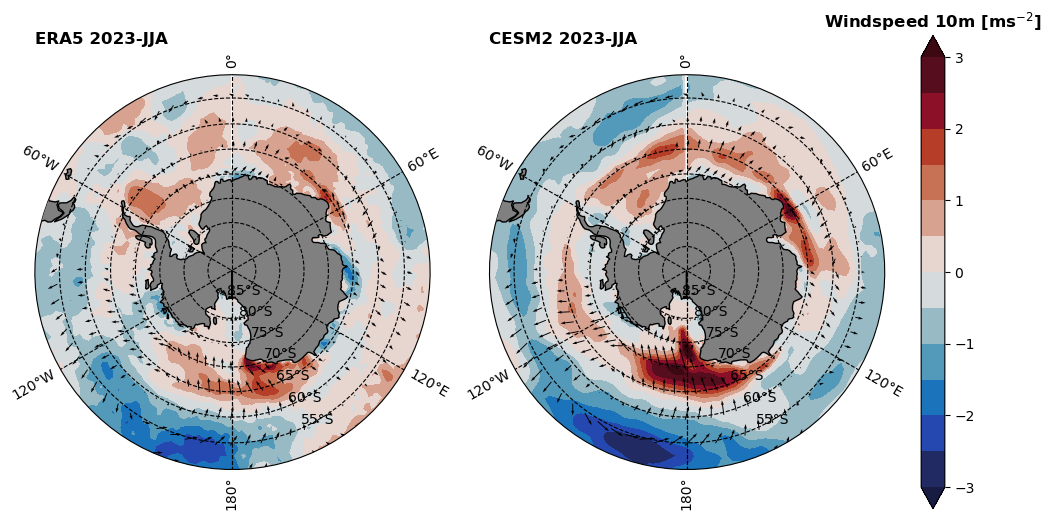

In [24]:
spatial_obs_plot(
    dfs={
        "era5": era5, 
        "cesm2": cesm2,
        # "diff": diff
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

### MSLP 

In [87]:
save_info = {
    "save": True,
    "path": "figures/mslp.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"MSLP [hPa]",
    "levels": np.arange(-12, 13, 1),
    "shared": True
}

era5 = {
    "title": "ERA5 2023-JJA",
    "ds": era5_atm_anoms["msl"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze()/100,
    "wind": [
        era5_atm_anoms["u10"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Zonal
        era5_atm_anoms["v10"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Meridional
        75
    ]
}

cesm2 = {
    "title": "CESM2 2023-JJA",
    "ds": cesm2_atm_anoms["PSL"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze()/100,
    "wind": [
        cesm2_atm_anoms["U"].isel(lev=0).resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Zonal
        cesm2_atm_anoms["V"].isel(lev=0).resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Meridional
        75,
    ]
}


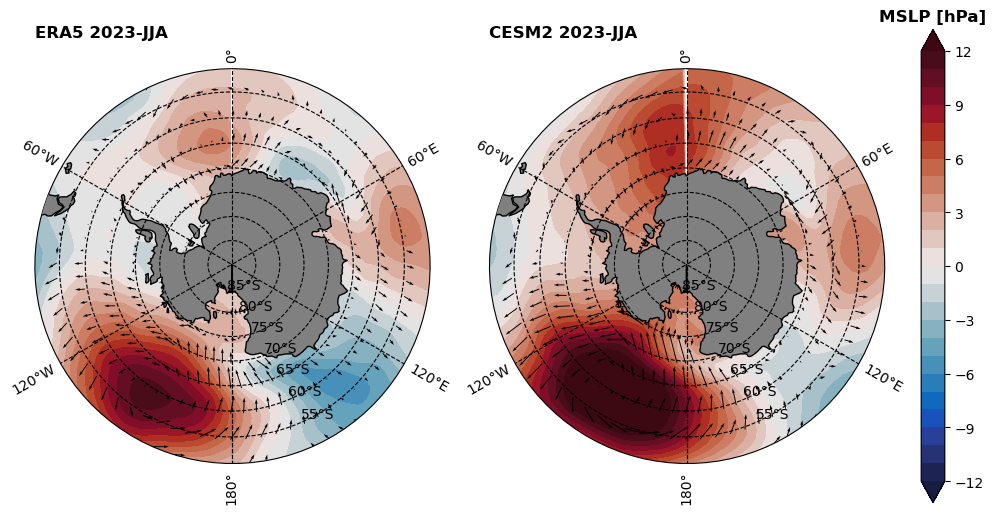

In [88]:
spatial_obs_plot(
    dfs={
        "era5": era5, 
        "cesm2": cesm2,
        # "diff": diff
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

### SST

In [43]:
cesm2_sst_anoms = xr.open_dataset("../data/cesm2_ocn-sst_monthly_1950-01_2023-12-anoms.nc")
cesm2_sst_anoms

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 901)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1949-12-01 1950-01-01 ... 2024-12-01
Data variables:
    SST      (time, lat, lon) float64 ...
Attributes:
    title:             cesm2.1.3_BHISTcmip6_f09_g17_ERA5_nudge
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  day_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-10-10 at 16:13:18.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [42]:
era5_atm_anoms

<xarray.Dataset>
Dimensions:  (time: 538, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-10-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    u10      (time, lat, lon) float64 ...
    v10      (time, lat, lon) float64 ...
    si10     (time, lat, lon) float64 ...
    t2m      (time, lat, lon) float64 ...
    msl      (time, lat, lon) float64 ...
    sst      (time, lat, lon) float64 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-17 07:41:27 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [100]:
save_info = {
    "save": True,
    "path": "figures/sst.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"SST [K]",
    "levels": np.arange(-3, 3.5, .5),
    "shared": True
}

era5 = {
    "title": "ERA5 2023-JJA",
    "ds": era5_atm_anoms["sst"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
}

cesm2 = {
    "title": "CESM2 2023-JJA",
    "ds": cesm2_sst_anoms["SST"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
}


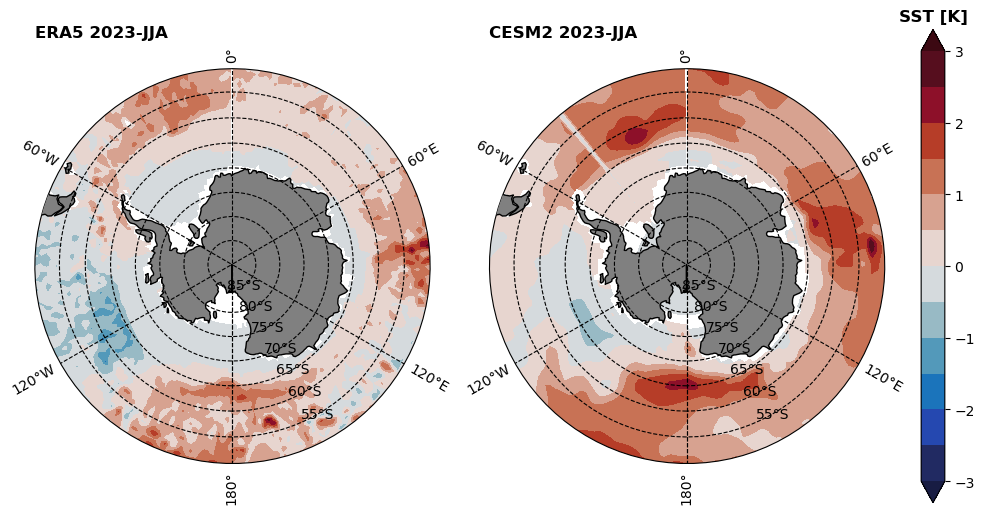

In [101]:
spatial_obs_plot(
    dfs={
        "era5": era5, 
        "cesm2": cesm2,
        # "diff": diff
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

In [68]:
save_info = {
    "save": True,
    "path": "figures/sst_2023MAM.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"SST [K]",
    "levels": np.arange(-3, 3.5, .5),
    "shared": True
}

era5 = {
    "title": "ERA5 2023-MAM",
    "ds": era5_atm_anoms["sst"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-03").squeeze(),
}

cesm2 = {
    "title": "CESM2 2023-MAM",
    "ds": cesm2_sst_anoms["SST"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-03").squeeze(),
}


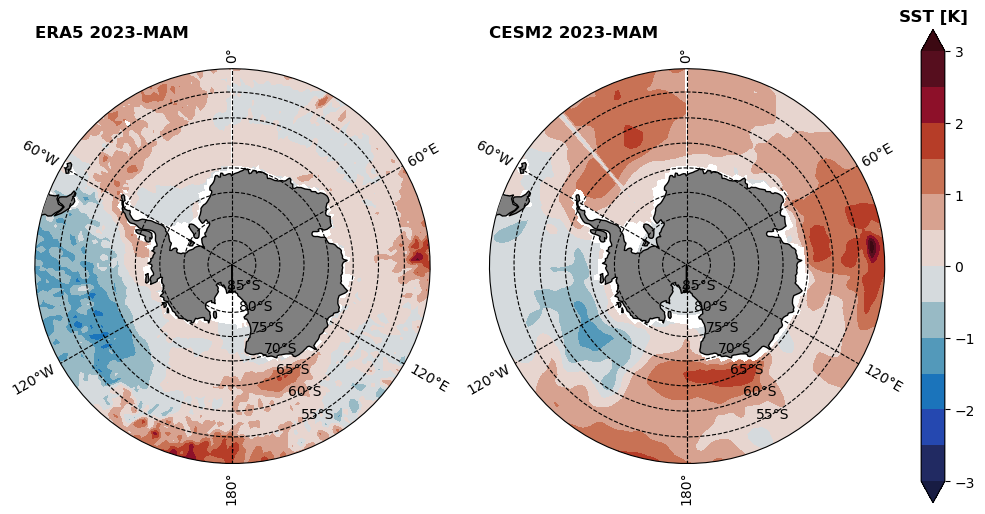

In [69]:
spatial_obs_plot(
    dfs={
        "era5": era5, 
        "cesm2": cesm2,
        # "diff": diff
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

In [72]:
save_info = {
    "save": True,
    "path": "figures/sst_2023DJF.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"SST [K]",
    "levels": np.arange(-3, 3.5, .5),
    "shared": True
}

era5 = {
    "title": "ERA5 2023-DJF",
    "ds": era5_atm_anoms["sst"].resample(time="QS-DEC").mean(dim="time").sel(time="2022-12").squeeze(),
}

cesm2 = {
    "title": "CESM2 2023-DJF",
    "ds": cesm2_sst_anoms["SST"].resample(time="QS-DEC").mean(dim="time").sel(time="2022-12").squeeze(),
}


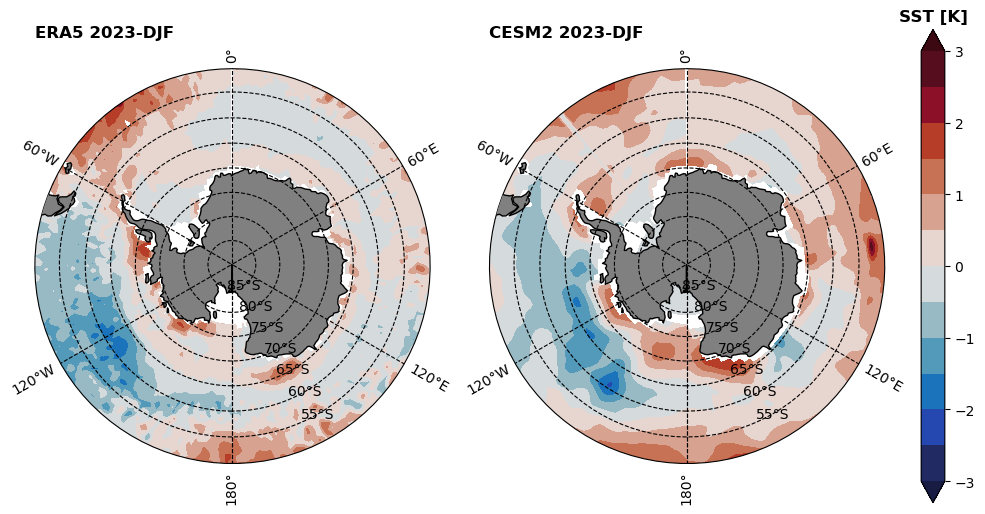

In [73]:
spatial_obs_plot(
    dfs={
        "era5": era5, 
        "cesm2": cesm2,
        # "diff": diff
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

In [102]:
save_info = {
    "save": True,
    "path": "figures/sst_2022JJA.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"SST [K]",
    "levels": np.arange(-3, 3.5, .5),
    "shared": True
}

era5 = {
    "title": "ERA5 2022-JJA",
    "ds": era5_atm_anoms["sst"].resample(time="QS-DEC").mean(dim="time").sel(time="2022-06").squeeze(),
}

cesm2 = {
    "title": "CESM2 2022-JJA",
    "ds": cesm2_sst_anoms["SST"].resample(time="QS-DEC").mean(dim="time").sel(time="2022-06").squeeze(),
}


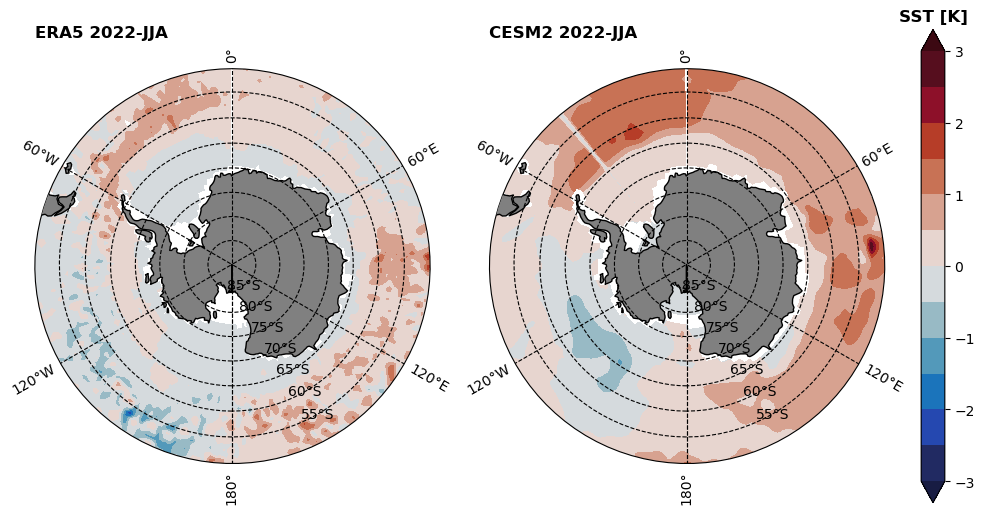

In [103]:
spatial_obs_plot(
    dfs={
        "era5": era5, 
        "cesm2": cesm2,
        # "diff": diff
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

### Z500

In [126]:
era5_atm_anoms_levels = xr.open_dataset("../data/ERA5_monthly_1979-01_2023-12_full-pressure-anoms.nc")
# era5_atm_anoms_levels.sel(level=500)["z"]

# cesm2_atm_anoms["Z3"].isel(lev=2)

<xarray.DataArray 'z' (time: 538, lat: 180, lon: 360)>
[34862400 values with dtype=float64]
Coordinates:
    level    int32 500
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-10-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential
    regrid_method:  bilinear
    operation:      temporal_avg
    mode:           departures
    freq:           month
    weighted:       True

In [148]:
save_info = {
    "save": True,
    "path": "figures/z500.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"Z500 [$m$]",
    "levels": np.arange(-100, 110, 10),
    "shared": True
}

era5 = {
    "title": "ERA5 2023-JJA",
    "ds": era5_atm_anoms_levels.sel(level=500)["z"].sel(time="2023-08").squeeze() / 9.8,
}

cesm2 = {
    "title": "CESM2 2023-JJA",
    "ds": cesm2_atm_anoms["Z3"].isel(lev=2).sel(time="2023-08").squeeze(),
}

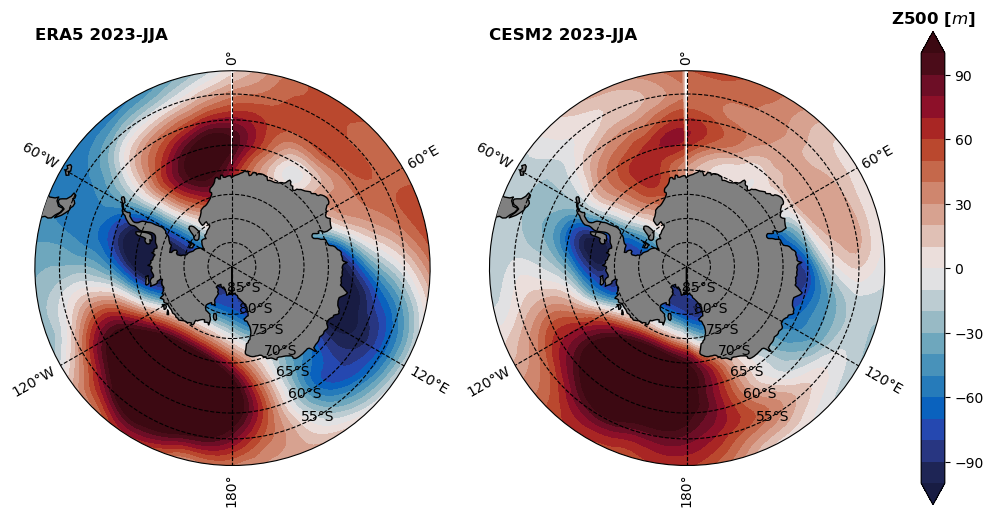

In [149]:
spatial_obs_plot(
    dfs={
        "era5": era5, 
        "cesm2": cesm2,
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

### 2TM 

In [120]:
cesm2_atm_anoms
era5_atm_anoms

<xarray.Dataset>
Dimensions:  (time: 538, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-10-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    u10      (time, lat, lon) float64 ...
    v10      (time, lat, lon) float64 ...
    si10     (time, lat, lon) float64 ...
    t2m      (time, lat, lon) float64 ...
    msl      (time, lat, lon) float64 ...
    sst      (time, lat, lon) float64 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-17 07:41:27 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [60]:
save_info = {
    "save": True,
    "path": "figures/t2m.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"T2M [K]",
    "levels": np.arange(-10, 11, 1),
    "shared": True
}

era5 = {
    "title": "ERA5 2023-JJA",
    "ds": era5_atm_anoms["t2m"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
}

cesm2 = {
    "title": "CESM2 2023-JJA",
    "ds": cesm2_atm_anoms["T"].isel(lev=0).resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
}


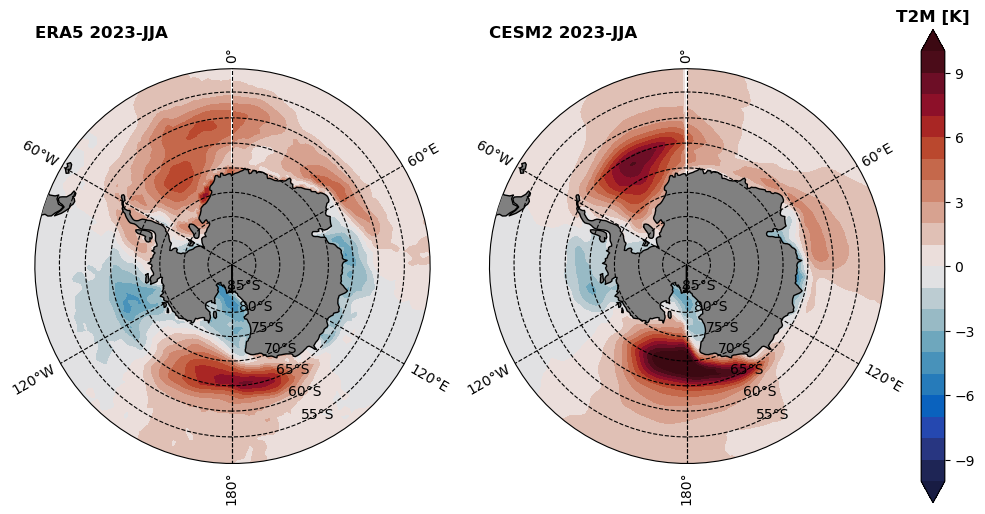

In [61]:
spatial_obs_plot(
    dfs={
        "era5": era5, 
        "cesm2": cesm2,
        # "diff": diff
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

### Ice

In [77]:
cesm2_ice_anoms

<xarray.Dataset>
Dimensions:  (time: 900, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-15 1950-02-15 ... 2024-12-15
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    aice     (time, lat, lon) float64 ...
    uvel     (time, lat, lon) float64 ...
    vvel     (time, lat, lon) float64 ...
    dvidtt   (time, lat, lon) float64 ...
    dvidtd   (time, lat, lon) float64 ...
    daidtt   (time, lat, lon) float64 ...
    daidtd   (time, lat, lon) float64 ...
    sithick  (time, lat, lon) float64 ...
Attributes:
    title:             cesm2.1.3_BHISTcmip6_f09_g17_ERA5_nudge
    contents:          Diagnostic and Prognostic Variables
    source:            Los Alamos Sea Ice Model (CICE) Version 5
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    comment:           All years have exactly 365 days
    comment2:          File written on model date 19500201
    comment3:          seconds elapsed into model date:      0
    conventions:       CF-1.0
    history:           This dataset was created on 2023-10-10 at 16:31
    io_flavor:         io_pio

In [89]:
cesm2_ice_anoms["daidtd"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze() + cesm2_ice_anoms["daidtt"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze()

<xarray.DataArray (lat: 180, lon: 360)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.24603626, -0.24675609, -0.24747885, ..., -0.24371276,
        -0.24460627, -0.24531957],
       [-0.24356075, -0.24299835, -0.24241805, ..., -0.24513714,
        -0.24463043, -0.24410489],
       [-0.26141562, -0.2616543 , -0.26189443, ..., -0.26070882,
        -0.2609428 , -0.26117846]])
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
    time     datetime64[ns] 2023-06-01

In [96]:
save_info = {
    "save": True,
    "path": "figures/daidt.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": "PuOr",
    "units": r"$\frac{dA}{dt}$ [%]",
    "shared": True,
    "levels": np.arange(-1, 1.1, .1)
}

cesm2_thermo = {
    "title": r"$\frac{dA}{dt}_{thermo}$ (2023-JJA)",
    "ds": cesm2_ice_anoms["daidtt"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
}

cesm2_dynam = {
    "title": r"$\frac{dA}{dt}_{dynam}$ (2023-JJA)",
    "ds": cesm2_ice_anoms["daidtd"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
    "wind": [
        cesm2_ice_anoms["uvel"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Zonal
        cesm2_ice_anoms["vvel"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Meridional
        .75
    ]
}

cesm2_sum= {
    "title": r"$\frac{dA}{dt}$ (2023-JJA)",
    "ds": cesm2_ice_anoms["daidtd"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze() + cesm2_ice_anoms["daidtt"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
    "wind": [
        cesm2_ice_anoms["uvel"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Zonal
        cesm2_ice_anoms["vvel"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Meridional
        .75
    ]
}

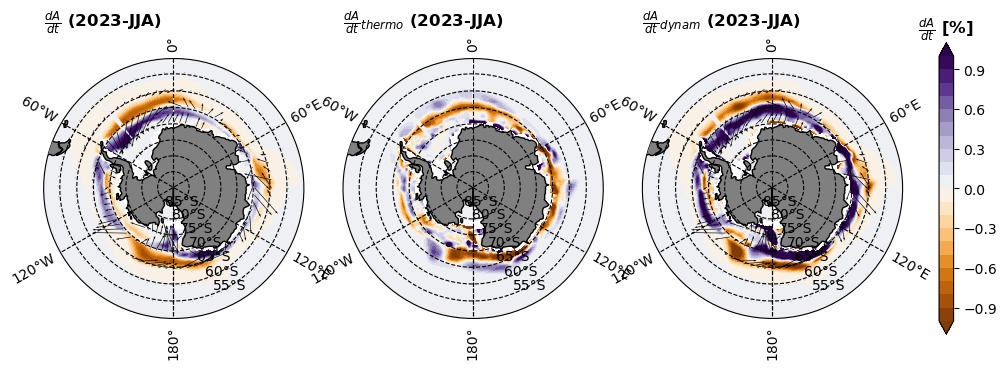

In [99]:
spatial_obs_plot(
    dfs={
        "cesm2_sum": cesm2_sum,
        "cesm2_thermo":  cesm2_thermo, 
        "cesm2_dynam": cesm2_dynam,
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

##  ENSO Composites

In [9]:
# Load Nino3.4 index
def read_csv(ds, fp, len_header): 
    index = []
    with open(fp, newline='') as csvfile:
        csvf = csv.reader(csvfile, delimiter=' ', quotechar='|')
        for i, row in enumerate(csvf):
            if i < len_header: continue
            if i == len_header: 
                header = row[0].split(',')
                continue
                
            ds[i-(len_header+1), :] = row[0].split(',')[1:]
            index.append(row[0].split(',')[0])
    
    ds = pd.DataFrame(data=ds, index=np.array(index), columns=header[1:])
    return ds
        
    
    
def read_txt(ds, fp, len_header, fill=-99.99):
    """
    Read arbitrary text file with header and data delineated with a space
    """
    nyrs, nmons = ds.shape
    years = []
    
    with open(fp) as f:
        lines = f.readlines()
        for n, line in enumerate(lines):
            if n < len_header: continue # skip header
            if n >= (nyrs+len_header): break # skip footer
            
            cidx = line.split()
            years.append(int(cidx[0]))
            ds[n-len_header, :] = cidx[1:]
            
    ds = xr.DataArray(
        data=ds,
        dims=["year", "month"],
        coords=dict(year=years, month=np.arange(1, 1+nmons))
    )
    ds = ds.where(ds != fill, np.nan)

    return ds

def load_nino34():
    nmonths = 12
    nino34 = read_txt(np.zeros((2024 - 1948, nmonths)), os.path.join("/glade/work/zespinosa/data/index/", "ENSO/Nino34_194801-202309_anoms.txt"), len_header=2)
    nino34 = nino34.stack(time=("year", "month"))
    nino34["time"] = np.arange("1948-01", "2024-01", dtype="datetime64[M]")
    # Select time overlapping with atmospheric data (1980 - 2020)
    nino34 = nino34.to_dataset(name="nino34")

    return nino34

nino34 = load_nino34()
nino34JJA = nino34.sel(time=slice("1980-01", "2023-08")).resample(time="QS-DEC").mean(dim="time")["nino34"][2::4]

In [44]:
nino34.sel(time=slice("1980-01", "2023-09-01"))

<xarray.Dataset>
Dimensions:  (time: 525)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2023-09-01
Data variables:
    nino34   (time) float64 0.54 0.22 0.03 -0.07 0.08 ... 0.84 1.02 1.35 1.59

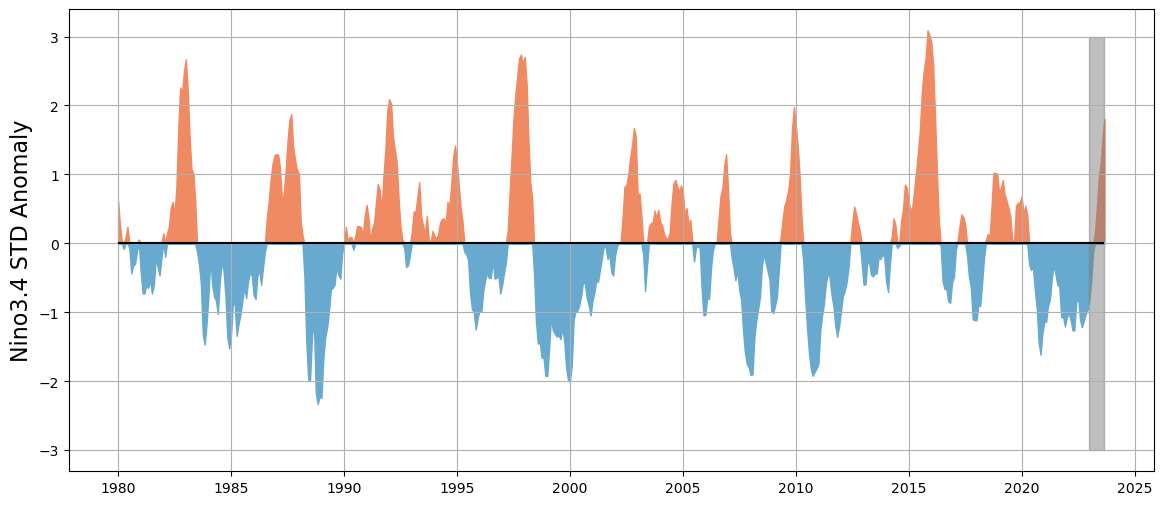

In [46]:
def time_series_plot(ts):
    colors = ['#ef8a62', '#67a9cf']
    time = ts.time

    ts = ts/ts.std("time")

    time_pos = time[ts > 0]
    ts_pos = ts[ts > 0]

    time_neg = time[ts <= 0]

    ts_pos = np.where(ts > 0, ts, 0)
    ts_neg = np.where(ts <= 0 , ts, 0)

    plt.fill_between(x=time, y1=0, y2=ts_pos, color=colors[0])
    plt.fill_between(x=time, y1=ts_neg, y2=0, color=colors[1])
    plt.hlines([0], time[0], time[-1], color="black")
    plt.grid()
    plt.ylabel(r"Nino3.4 STD Anomaly", fontsize=16)
    plt.fill_between(["2023-01-01", "2023-09-01"], -3, 3, color='gray', alpha=0.5)
    fig = plt.gcf()
    fig.set_size_inches(14, 6)
    plt.savefig("figures/nino34.png", dpi=1200, bbox_inches="tight")

time_series_plot(ts=nino34["nino34"].sel(time=slice("1980-01", "2023-09-01")))

In [10]:
def nino_composite(nino34, cesm2):
    pos_enso = xr.where(nino34 > nino34.std("time"), cesm2, np.nan)
    neg_enso = xr.where(nino34 < -nino34.std("time"), cesm2, np.nan)

    pos_enso = pos_enso.mean(dim="time", skipna=True)
    neg_enso = neg_enso.mean(dim="time", skipna=True)

    return pos_enso, neg_enso, pos_enso - neg_enso

In [11]:
cesm2_ice_anoms_JJA = cesm2_ice_anoms["aice"].sel(time=slice("1980-01", "2023-08")).resample(time="QS-DEC").mean(dim="time")[2::4]
pos_enso_ice, neg_enso_ice, diff_enso_ice = nino_composite(nino34JJA, cesm2_ice_anoms_JJA)

/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages/xarray/coding/cftime_offsets.py:292: CFWarning: this date/calendar/year zero convention is not supported by CF
  return date.replace(year=year, month=month, day=day)
/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages/xarray/coding/cftime_offsets.py:292: CFWarning: this date/calendar/year zero convention is not supported by CF
  return date.replace(year=year, month=month, day=day)


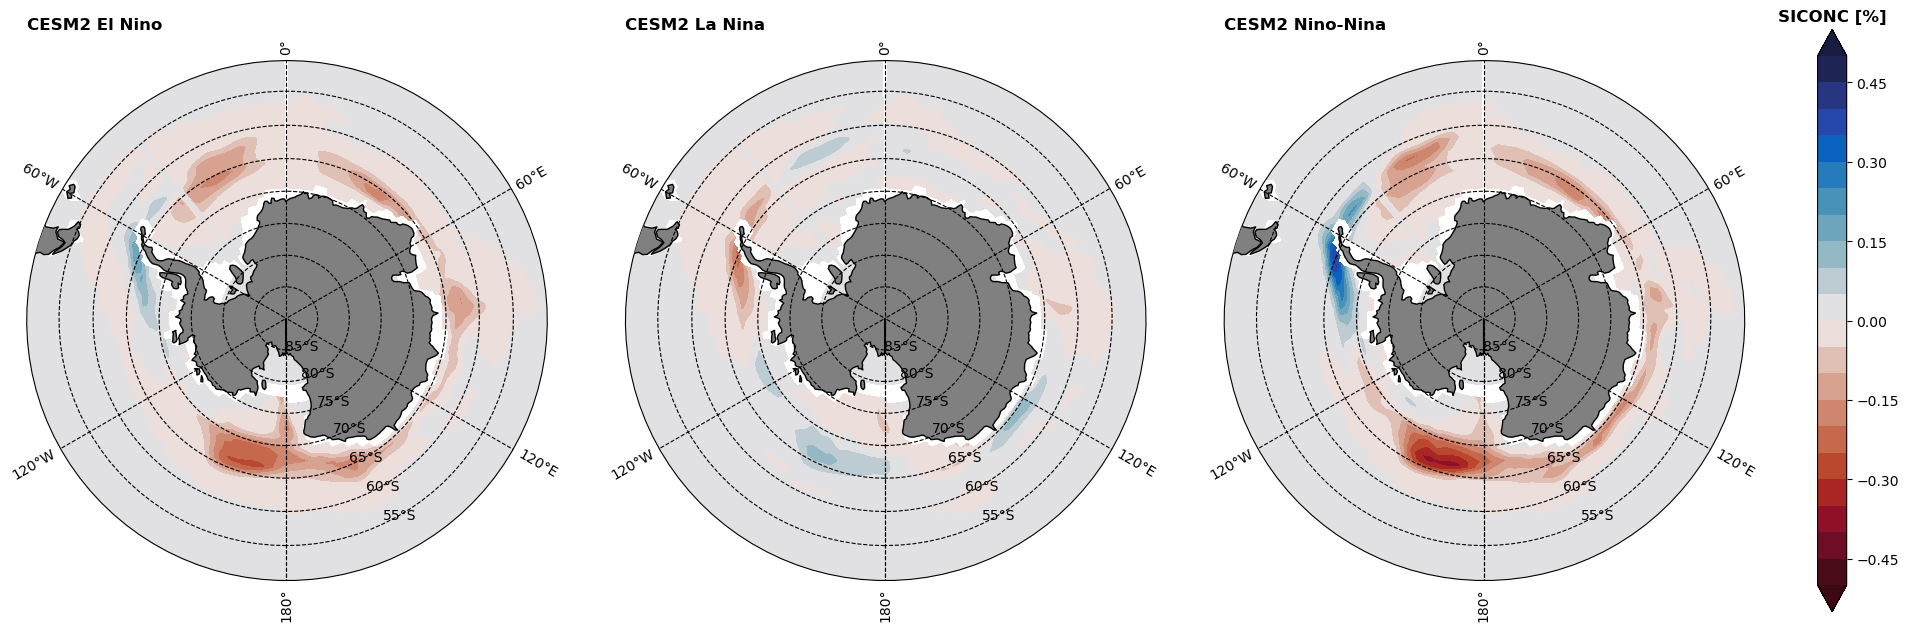

In [12]:
save_info = {
    "save": True,
    "path": "figures/enso_composites.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": cmocean.cm.balance_r,
    "units": "SICONC [%]",
    "shared": True,
    "levels": np.arange(-.5, .55, .05),
}

cesm2_pos = {
    "title": "CESM2 El Nino",
    "ds": pos_enso_ice,
    "edge": pos_enso_ice,
    "edge_clim": cesm2_ice_clim["aice"].resample(time="QS-DEC").mean(dim="time").isel(time=2).squeeze(),
}

cesm2_neg = {
    "title": "CESM2 La Nina",
    "ds": neg_enso_ice,
    "edge": neg_enso_ice,
    "edge_clim": cesm2_ice_clim["aice"].resample(time="QS-DEC").mean(dim="time").isel(time=2).squeeze(),
}


cesm2_diff = {
    "title": "CESM2 Nino-Nina",
    "ds": diff_enso_ice,
}

spatial_obs_plot(
    dfs={
        "cesm2_pos": cesm2_pos,
        "cesm2_neg": cesm2_neg,
        "cesm2_diff":  cesm2_diff, 
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

### ENSO MSLP ERA5

In [56]:
era5_atm_anoms_MSLP = era5_atm_anoms["msl"].sel(time=slice("1980-01", "2023-08")).resample(time="QS-DEC").mean(dim="time")[2::4]
era5_atm_anoms_u10 = era5_atm_anoms["u10"].sel(time=slice("1980-01", "2023-08")).resample(time="QS-DEC").mean(dim="time")[2::4]
era5_atm_anoms_v10 = era5_atm_anoms["v10"].sel(time=slice("1980-01", "2023-08")).resample(time="QS-DEC").mean(dim="time")[2::4]

pos_enso_mslp, neg_enso_mslp, diff_enso_mslp = nino_composite(nino34JJA, era5_atm_anoms_MSLP)
pos_enso_u10, neg_enso_u10, diff_enso_u10 = nino_composite(nino34JJA, era5_atm_anoms_u10)
pos_enso_v10, neg_enso_v10, diff_enso_v10 = nino_composite(nino34JJA, era5_atm_anoms_v10)

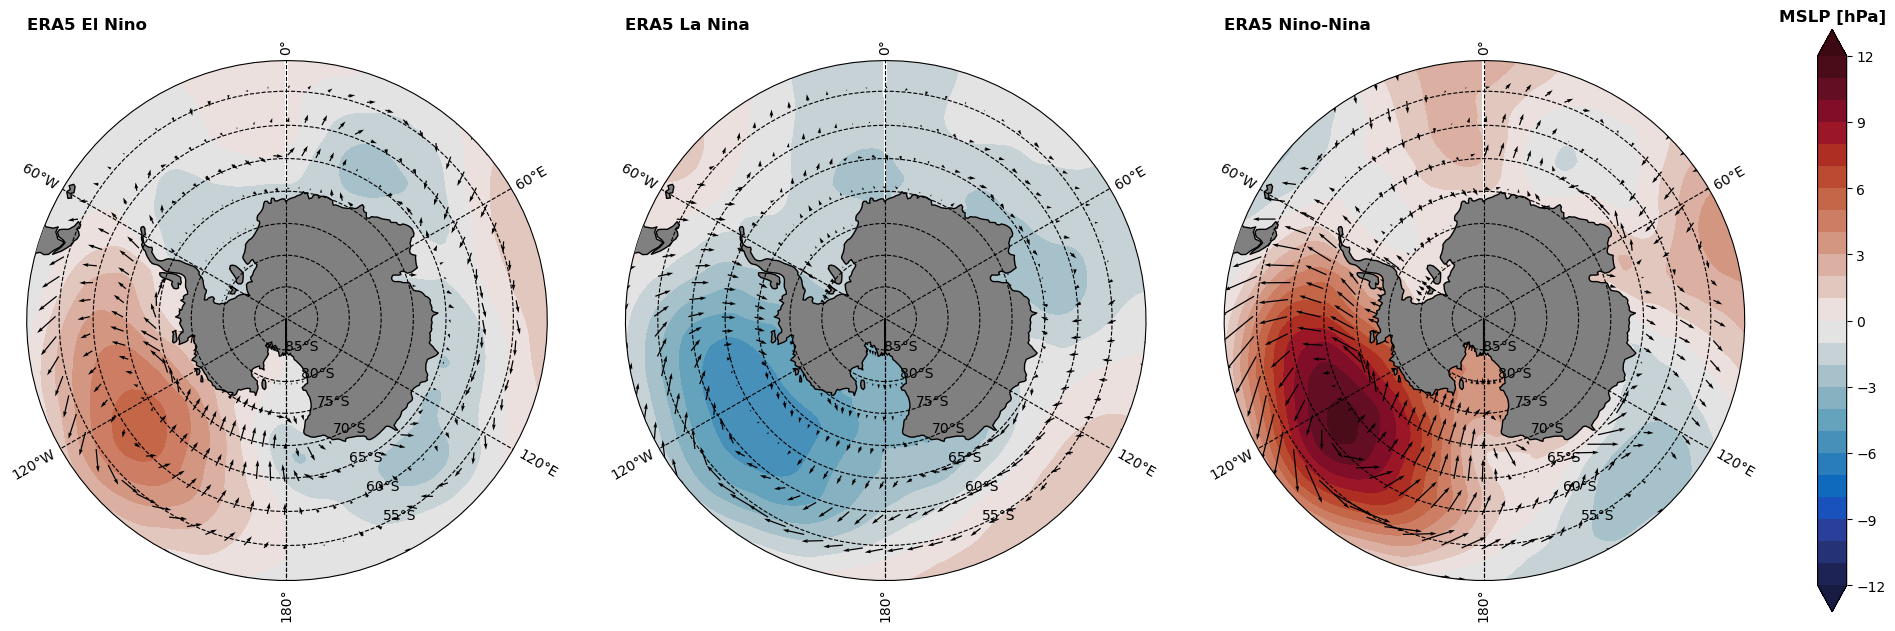

In [57]:
save_info = {
    "save": True,
    "path": "figures/era5_enso_composites_mslp.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"MSLP [hPa]",
    "levels": np.arange(-12, 13, 1),
    "shared": True
}

pos_enso = {
    "title": "ERA5 El Nino",
    "ds": pos_enso_mslp/100,
    "wind": [
        pos_enso_u10, # Zonal
        pos_enso_v10, # Meridional
        40
    ]
}
neg_enso = {
    "title": "ERA5 La Nina",
    "ds": neg_enso_mslp/100,
    "wind": [
        neg_enso_u10, # Zonal
        neg_enso_v10, # Meridional
        40
    ]
}

diff_enso = {
    "title": "ERA5 Nino-Nina",
    "ds": diff_enso_mslp/100,
    "wind": [
        diff_enso_u10, # Zonal
        diff_enso_v10, # Meridional
        40
    ]
}

spatial_obs_plot(
    dfs={
        "cesm2_pos": pos_enso,
        "cesm2_neg": neg_enso,
        "cesm2_diff":  diff_enso, 
    }, 
    cmap_info=cmap_info,
    save_info=save_info, 
)

### ENSO MSLP CESM2

In [13]:
cesm2_atm_anoms_MSLP = cesm2_atm_anoms["PSL"].sel(time=slice("1980-01", "2023-08")).resample(time="QS-DEC").mean(dim="time")[2::4]
cesm2_atm_anoms_u10 = cesm2_atm_anoms["U"].isel(lev=0).sel(time=slice("1980-01", "2023-08")).resample(time="QS-DEC").mean(dim="time")[2::4]
cesm2_atm_anoms_v10 = cesm2_atm_anoms["V"].isel(lev=0).sel(time=slice("1980-01", "2023-08")).resample(time="QS-DEC").mean(dim="time")[2::4]

pos_enso_mslp, neg_enso_mslp, diff_enso_mslp = nino_composite(nino34JJA, cesm2_atm_anoms_MSLP)
pos_enso_u10, neg_enso_u10, diff_enso_u10 = nino_composite(nino34JJA, cesm2_atm_anoms_u10)
pos_enso_v10, neg_enso_v10, diff_enso_v10 = nino_composite(nino34JJA, cesm2_atm_anoms_v10)


In [14]:
save_info = {
    "save": True,
    "path": "figures/enso_composites_mslp.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"MSLP [hPa]",
    "levels": np.arange(-12, 13, 1),
    "shared": True
}

pos_enso = {
    "title": "CESM El Nino",
    "ds": pos_enso_mslp/100,
    "wind": [
        pos_enso_u10, # Zonal
        pos_enso_v10, # Meridional
        40
    ]
}

neg_enso = {
    "title": "CESM La Nina",
    "ds": neg_enso_mslp/100,
    "wind": [
        neg_enso_u10, # Zonal
        neg_enso_v10, # Meridional
        40
    ]
}

diff_enso = {
    "title": "CESM Nino-Nina",
    "ds": diff_enso_mslp/100,
    "wind": [
        diff_enso_u10, # Zonal
        diff_enso_v10, # Meridional
        40
    ]
}

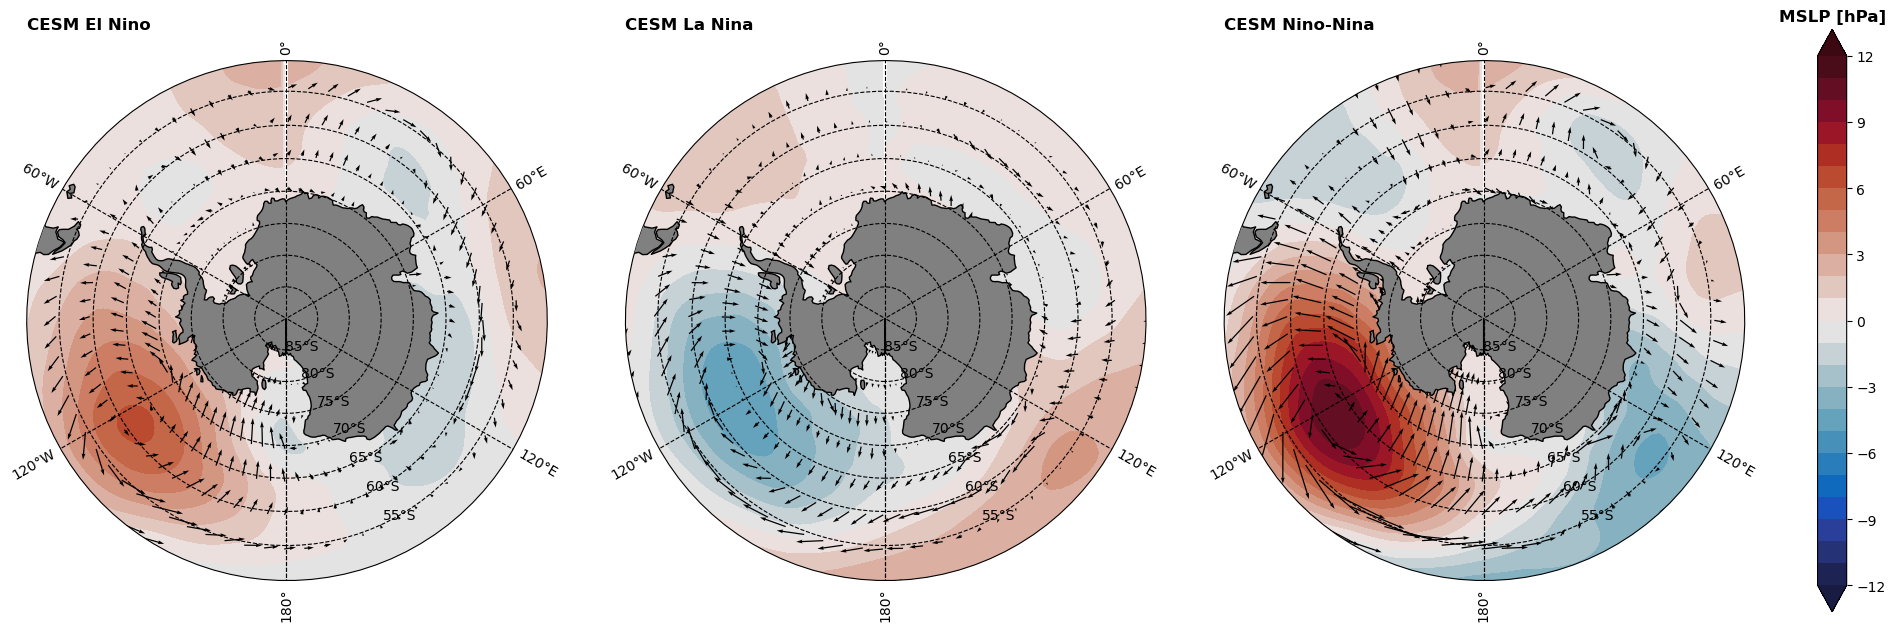

In [15]:
spatial_obs_plot(
    dfs={
        "cesm2_pos": pos_enso,
        "cesm2_neg": neg_enso,
        "cesm2_diff":  diff_enso, 
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

### ENSO ATM

In [16]:
enso_cesm2_atm_anoms = xr.open_dataset("../data/enso_cesm2_atm_monthly_1950-01_2023-12-anoms.nc")
enso_cesm2_atm_anoms

<xarray.Dataset>
Dimensions:  (time: 888, lat: 180, lon: 360, lev: 3)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-15 1950-02-15 ... 2023-12-15
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lev      (lev) float64 992.6 859.5 524.7
Data variables:
    PSL      (time, lat, lon) float64 ...
    T        (time, lev, lat, lon) float64 ...
    TS       (time, lat, lon) float64 ...
    U        (time, lev, lat, lon) float64 ...
    U10      (time, lat, lon) float64 ...
    V        (time, lev, lat, lon) float64 ...
    Z3       (time, lev, lat, lon) float64 ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              cesm2.1.3_BHISTcmip6_f09_g17_ERA5_nudge
    logname:           zespinosa
    host:              cheyenne2
    initial_file:      b.e21.BHIST.f09_g17.CMIP6-historical.001.cam.i.1950-01...
    topography_file:   /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv_0.9x1...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1

In [53]:
save_info = {
    "save": True,
    "path": "figures/enso_t2m.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": [cmocean.cm.balance, cmocean.cm.balance],
    "units": [r"T2M [K]", r"T2M [K]"],
    "levels": [np.arange(-10, 10.5, .5), np.arange(-5, 5.2, .2)],
    "shared": False
}

# era5 = {
#     "title": "ERA5 2023-JJA",
#     "ds": era5_atm_anoms["t2m"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
# }

cesm2 = {
    "title": "CESM2 2023-JJA",
    "ds": cesm2_atm_anoms["T"].isel(lev=0).resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
}

cesm2_enso = {
    "title": "CESM2 2023-JJA",
    "ds": cesm2_atm_anoms["T"].isel(lev=0).resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze() - enso_cesm2_atm_anoms["T"].isel(lev=0).resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
}


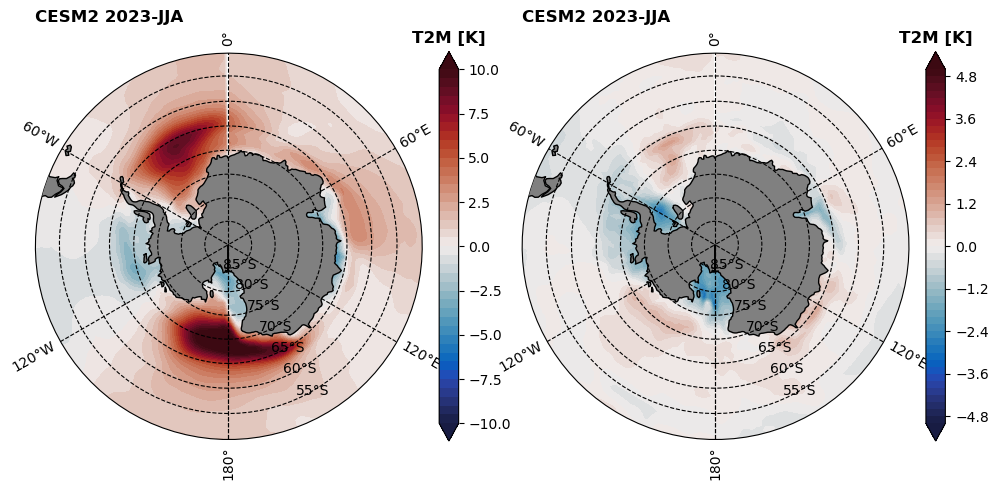

In [54]:
spatial_obs_plot(
    dfs={
        "cesm2": cesm2,
        "cesm2_enso":  cesm2_enso, 
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

In [59]:
save_info = {
    "save": True,
    "path": "figures/enso_mslp.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"MSLP [hPa]",
    "levels": np.arange(-12, 12.5, .5),
    "shared": True
}

era5 = {
    "title": "ERA5 2023-JJA",
    "ds": era5_atm_anoms["msl"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze()/100,
    "wind": [
        era5_atm_anoms["u10"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Zonal
        era5_atm_anoms["v10"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Meridional
        75
    ]
}

cesm2 = {
    "title": "CESM2 2023-JJA",
    "ds": cesm2_atm_anoms["PSL"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze()/100,
    "wind": [
        cesm2_atm_anoms["U"].isel(lev=0).resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Zonal
        cesm2_atm_anoms["V"].isel(lev=0).resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Meridional
        75,
    ]
}

cesm2_enso = {
    "title": "CESM2 (ENSO Removed) 2023-JJA",
    "ds": cesm2_atm_anoms["PSL"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze()/100 - enso_cesm2_atm_anoms["PSL"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze()/100,
    "wind": [
        cesm2_atm_anoms["U"].isel(lev=0).resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze() - enso_cesm2_atm_anoms["U"].isel(lev=0).resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Zonal
        cesm2_atm_anoms["V"].isel(lev=0).resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze() - enso_cesm2_atm_anoms["V"].isel(lev=0).resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Meridional
        30,
    ]
}

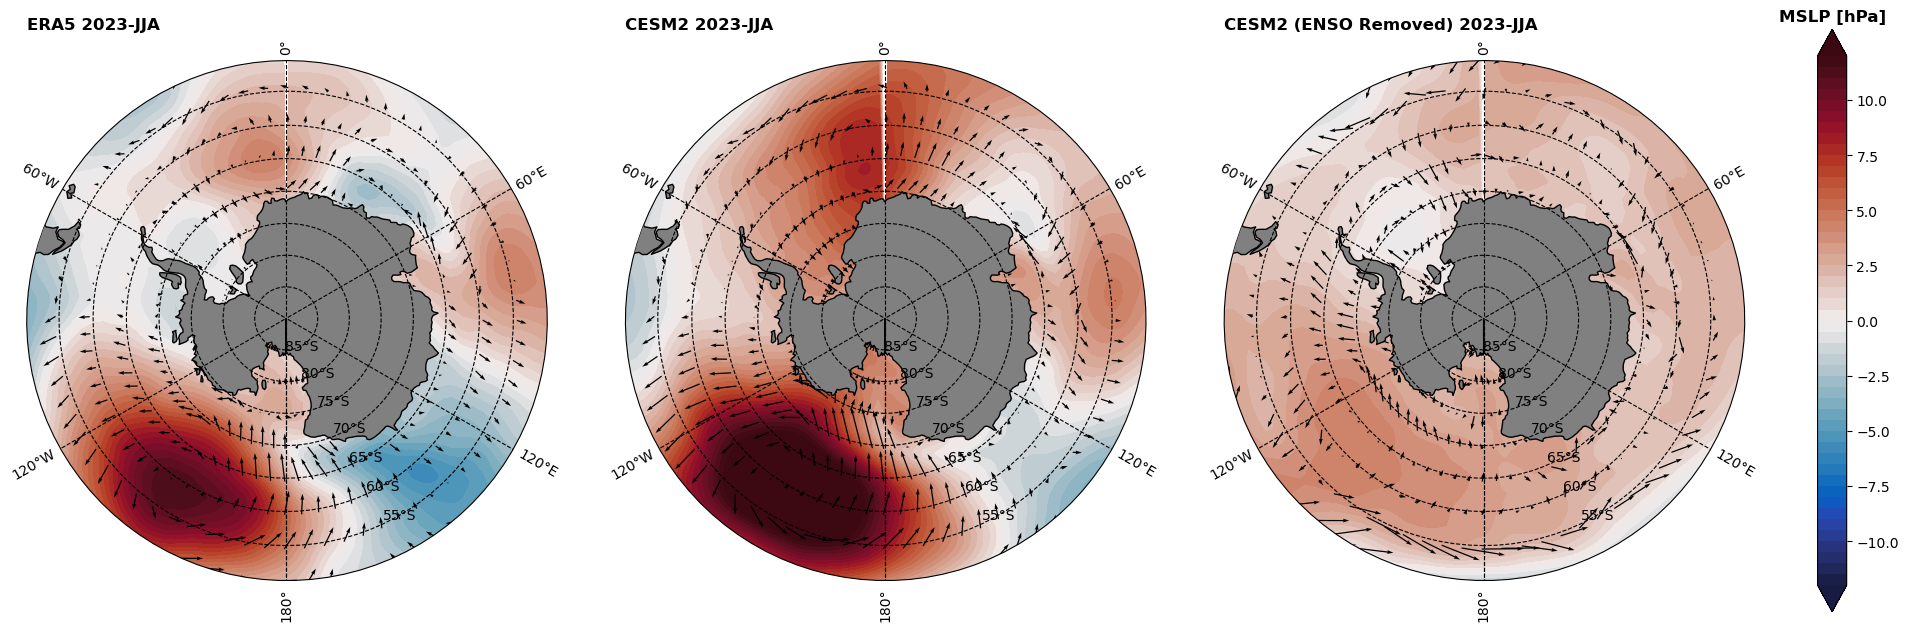

In [32]:
spatial_obs_plot(
    dfs={
        "era5": era5,
        "cesm2": cesm2,
        "cesm2_enso":  cesm2_enso, 
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

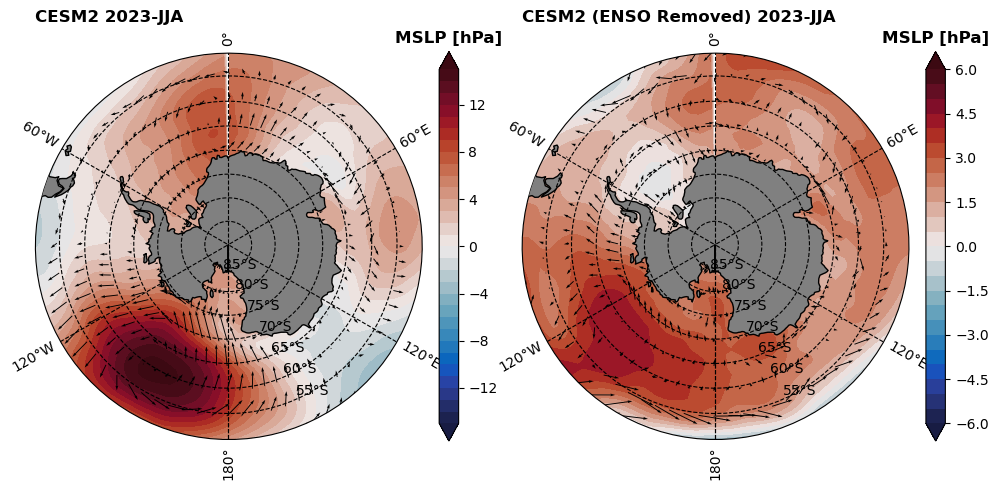

In [62]:
save_info = {
    "save": True,
    "path": "figures/enso_mslp_noshared.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": [cmocean.cm.balance, cmocean.cm.balance],
    "units": [r"MSLP [hPa]", r"MSLP [hPa]"],
    "shared": False,
    "levels": [np.arange(-15, 16, 1), np.arange(-6, 6.5, .5)]
}
spatial_obs_plot(
    dfs={
        "cesm2": cesm2,
        "cesm2_enso":  cesm2_enso, 
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

### ENSO Ice

In [26]:
enso_cesm2_ice_anoms = xr.open_dataset("../data/enso_cesm2_ice_monthly_1950-01_2023-12-anoms.nc")
enso_cesm2_ice_anoms

<xarray.Dataset>
Dimensions:  (time: 888, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-15 1950-02-15 ... 2023-12-15
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    aice     (time, lat, lon) float64 ...
    uvel     (time, lat, lon) float64 ...
    vvel     (time, lat, lon) float64 ...
    dvidtt   (time, lat, lon) float64 ...
    dvidtd   (time, lat, lon) float64 ...
    daidtt   (time, lat, lon) float64 ...
    daidtd   (time, lat, lon) float64 ...
    sithick  (time, lat, lon) float64 ...
Attributes:
    title:             cesm2.1.3_BHISTcmip6_f09_g17_ERA5_nudge
    contents:          Diagnostic and Prognostic Variables
    source:            Los Alamos Sea Ice Model (CICE) Version 5
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    comment:           All years have exactly 365 days
    comment2:          File written on model date 19500201
    comment3:          seconds elapsed into model date:      0
    conventions:       CF-1.0
    history:           This dataset was created on 2023-10-10 at 16:31
    io_flavor:         io_pio

/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages/xarray/coding/cftime_offsets.py:292: CFWarning: this date/calendar/year zero convention is not supported by CF
  return date.replace(year=year, month=month, day=day)
/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages/xarray/coding/cftime_offsets.py:292: CFWarning: this date/calendar/year zero convention is not supported by CF
  return date.replace(year=year, month=month, day=day)


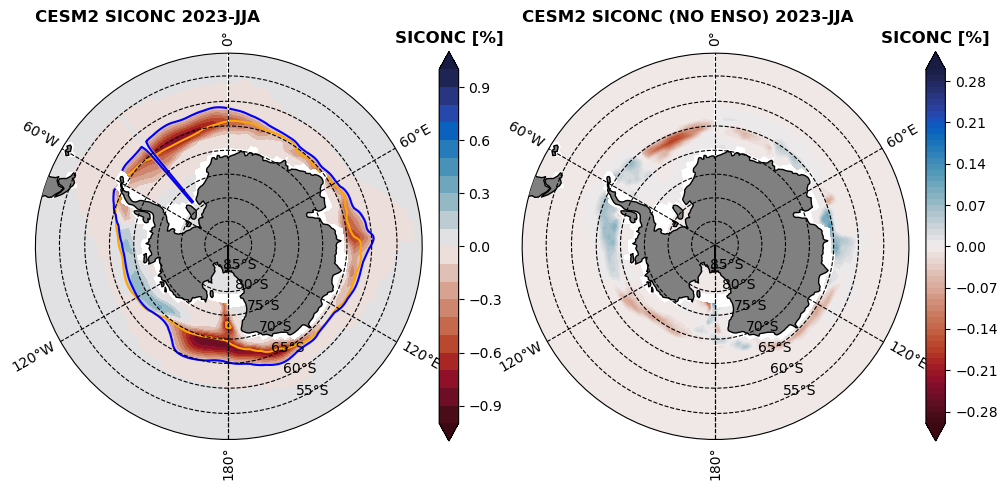

In [29]:
save_info = {
    "save": True,
    "path": "figures/enso_siconc.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": [cmocean.cm.balance_r, cmocean.cm.balance_r],
    "units": ["SICONC [%]", "SICONC [%]"],
    "shared": False,
    "levels": [np.arange(-1, 1.1, .1), np.arange(-.3, .31, .01)]
}

cesm2_siconc = {
    "title": "CESM2 SICONC 2023-JJA",
    "ds": cesm2_ice_anoms["aice"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
    "edge": cesm2_ice["aice"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
    "edge_clim": cesm2_ice_clim["aice"].resample(time="QS-DEC").mean(dim="time").isel(time=2).squeeze(),
}

cesm2_siconc_noenso = {
    "title": "CESM2 SICONC (NO ENSO) 2023-JJA",
    "ds": cesm2_ice_anoms["aice"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze() - enso_cesm2_ice_anoms["aice"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
    "edge": cesm2_ice["aice"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
    "edge_clim": cesm2_ice_clim["aice"].resample(time="QS-DEC").mean(dim="time").isel(time=2).squeeze(),
}

spatial_obs_plot(
    dfs={
        "cesm2_siconc":  cesm2_siconc, 
        "cesm2_siconc_noenso": cesm2_siconc_noenso,
    }, 
    cmap_info=cmap_info, 
    save_info=save_info,
)